In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
base_dir = '/content/drive/MyDrive/split_dataset'  # Adjusted path
class_names = ['dyslexic', 'normal']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
test_dir = f"{base_dir}/test"

In [5]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Test samples:", len(test_dataset))


Test samples: 1509


In [6]:
from google.colab import files
uploaded = files.upload()

Saving final_modeldense.pth to final_modeldense.pth
Saving best.pth to best (1).pth


In [ ]:
import os

# Check if uploaded models exist
print("Files in current directory:")
for file in os.listdir('.'):
    if file.endswith('.pth'):
        print(f"✅ {file}")

# Also check file sizes to make sure uploads completed
if os.path.exists('Final_modeldense.pth'):
    size = os.path.getsize('Final_modeldense.pth') / (1024*1024)  # MB
    print(f"Final_modeldense.pth: {size:.2f} MB")

if os.path.exists('Test_model.pth'):
    size = os.path.getsize('Test_model.pth') / (1024*1024)  # MB
    print(f"Test_model.pth: {size:.2f} MB")

In [10]:
import torch
import torch.nn as nn
from torchvision import models
import os

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check models exist
print("Model files:")
print(f"Final_modeldense.pth exists: {os.path.exists('Final_modeldense.pth')}")
print(f"Test_model.pth exists: {os.path.exists('best (1).pth')}")

# Try loading sentence model
try:
    print("Loading sentence model...")
    model_sentence = models.densenet121(pretrained=False)
    model_sentence.classifier = torch.nn.Linear(1024, 2)
    model_sentence.load_state_dict(torch.load('final_modeldense.pth', map_location=device))
    model_sentence.to(device).eval()
    print("✅ Sentence model loaded successfully")
except Exception as e:
    print(f"❌ Error loading sentence model: {e}")

# Try loading character model
try:
    print("Loading character model...")
    model_char = models.mobilenet_v3_small(pretrained=False)
    model_char.classifier = torch.nn.Sequential(
        torch.nn.Linear(576, 256),
        torch.nn.Hardswish(),
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(256, 2)
    )
    model_char.load_state_dict(torch.load('best (1).pth', map_location=device))
    model_char.to(device).eval()
    print("✅ Character model loaded successfully")
except Exception as e:
    print(f"❌ Error loading character model: {e}")

Using device: cuda
Model files:
Final_modeldense.pth exists: False
Test_model.pth exists: True
Loading sentence model...
✅ Sentence model loaded successfully
Loading character model...
✅ Character model loaded successfully


In [ ]:
ls

In [ ]:
from google.colab import files

# Upload both your DenseNet and MobileNet models
uploaded = files.upload()  # a file picker will open


In [ ]:
!ls

In [27]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

# -----------------------------
# Data Loading
# -----------------------------
# Transforms for sentence model (should match training transforms)
sentence_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Character model transforms
char_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# -----------------------------
# Model Loading
# -----------------------------
print("\n🔄 Loading models...")

# Load sentence model (DenseNet121)
model_sentence = models.densenet121(pretrained=False)
model_sentence.classifier = torch.nn.Linear(1024, 2)

try:
    state_dict = torch.load('final_modeldense.pth', map_location=device)  # ✅ DenseNet weights
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    elif isinstance(state_dict, dict) and 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    model_sentence.load_state_dict(state_dict, strict=False)
except Exception as e:
    print(f"⚠️ Error loading DenseNet: {e}")
    print("Attempting to load entire DenseNet model...")
    model_sentence = torch.load('final_modeldense.pth', map_location=device)

model_sentence.to(device).eval()
print("✅ Sentence (DenseNet) model loaded")

# Load character model (MobileNetV3)
model_char = models.mobilenet_v3_small(pretrained=False)
model_char.classifier = torch.nn.Sequential(
    torch.nn.Linear(576, 256),
    torch.nn.Hardswish(),
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(256, 2)
)

try:
    state_dict = torch.load('best (1).pth', map_location=device)  # ✅ MobileNet weights
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    elif isinstance(state_dict, dict) and 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    model_char.load_state_dict(state_dict, strict=True)
except Exception as e:
    print(f"⚠️ Error loading MobileNet: {e}")
    print("Attempting to load entire MobileNet model...")
    model_char = torch.load('best (1).pth', map_location=device)

model_char.to(device).eval()
print("✅ Character (MobileNet) model loaded")


# -----------------------------
# Prediction Functions
# -----------------------------
def predict_sentence_tensor(image_tensor, model, device):
    """Predict using sentence-level model"""
    with torch.no_grad():
        output = model(image_tensor.to(device))
        prob = F.softmax(output, dim=1).cpu().numpy()[0]
    return prob

def predict_char_model(image_path, model, device):
    """Predict using character-level model"""
    image = Image.open(image_path).convert('RGB')
    image = char_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        prob = F.softmax(output, dim=1).cpu().numpy()[0]

    return prob

# -----------------------------
# Fusion Function
# -----------------------------
def fuse_probs(prob_sentence, prob_char, w_sentence=0.7, w_char=0.3):
    """Fuse predictions from both models using weighted average"""
    return w_sentence * np.array(prob_sentence) + w_char * np.array(prob_char)

# -----------------------------
# Main Fusion Evaluation
# -----------------------------
# Fusion weights
w_sentence = 0.7
w_char = 0.3

print(f"\n🚀 Starting Fusion Model Evaluation")
print(f"⚖️ Fusion weights: Sentence={w_sentence}, Character={w_char}")
print("="*80)

# Evaluation
correct = 0
total = 0
all_labels = []
all_preds = []

for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Processing batches")):
    images = images.to(device)
    labels = labels.to(device)

    for i in range(images.size(0)):
        image_tensor = images[i].unsqueeze(0)
        true_label = labels[i].item()

        # Get image path
        sample_idx = batch_idx * test_loader.batch_size + i
        if sample_idx >= len(test_loader.dataset.samples):
            break
        image_path = test_loader.dataset.samples[sample_idx][0]

        # Get predictions from both models
        prob_sentence = predict_sentence_tensor(image_tensor, model_sentence, device)
        prob_char = predict_char_model(image_path, model_char, device)

        # Fuse predictions
        fused_prob = fuse_probs(prob_sentence, prob_char, w_sentence, w_char)

        # ✅ Apply threshold (binary classification only)
        threshold = 0.73 # 👈 adjust this value as needed
        if fused_prob[1] >= threshold:
            pred_label = 1
        else:
            pred_label = 0

        # Get class names
        class_names = list(test_loader.dataset.class_to_idx.keys())
        true_class = class_names[true_label] if true_label < len(class_names) else f"class_{true_label}"
        pred_class = class_names[pred_label] if pred_label < len(class_names) else f"class_{pred_label}"

        # Display result with individual model confidences
        filename = os.path.basename(image_path)
        sent_conf = prob_sentence[pred_label]
        char_conf = prob_char[pred_label]
        fused_conf = fused_prob[pred_label]

        # Show predictions from each model
        sent_pred = int(np.argmax(prob_sentence))
        char_pred = int(np.argmax(prob_char))
        sent_pred_class = class_names[sent_pred]
        char_pred_class = class_names[char_pred]

        agreement = "✓" if sent_pred == char_pred else "✗"

        print(f"{filename:<30} | True: {true_class:<10} | "
        f"Pred: {pred_class:<10} ({fused_conf:.3f})")


        # Track results
        all_labels.append(true_label)
        all_preds.append(pred_label)
        total += 1
        if pred_label == true_label:
            correct += 1


# Final Results
print("\n" + "="*80)
accuracy = (correct / total) * 100 if total > 0 else 0
print(f"🎯 FUSION MODEL RESULTS:")
print(f"Overall Accuracy: {accuracy:.2f}% ({correct}/{total})")

# Per-class accuracy
class_names = list(test_loader.dataset.class_to_idx.keys())
for i, class_name in enumerate(class_names):
    class_correct = sum(1 for true, pred in zip(all_labels, all_preds) if true == i and pred == i)
    class_total = sum(1 for label in all_labels if label == i)
    if class_total > 0:
        class_acc = (class_correct / class_total) * 100
        print(f"{class_name} Accuracy: {class_acc:.2f}% ({class_correct}/{class_total})")

print("✅ Evaluation completed!")

🔧 Using device: cuda

🔄 Loading models...
✅ Sentence (DenseNet) model loaded
✅ Character (MobileNet) model loaded

🚀 Starting Fusion Model Evaluation
⚖️ Fusion weights: Sentence=0.7, Character=0.3


Processing batches:   0%|          | 0/95 [00:00<?, ?it/s]

007.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
010.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
014.png                        | True: dyslexic   | Pred: dyslexic   (0.788)
017.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
025.png                        | True: dyslexic   | Pred: dyslexic   (0.783)
032.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
053.png                        | True: dyslexic   | Pred: dyslexic   (0.801)
054.png                        | True: dyslexic   | Pred: dyslexic   (0.804)
062.png                        | True: dyslexic   | Pred: dyslexic   (0.794)
064.png                        | True: dyslexic   | Pred: dyslexic   (0.796)
069.png                        | True: dyslexic   | Pred: dyslexic   (0.800)
072.png                        | True: dyslexic   | Pred: dyslexic   (0.804)
078.png                        | True: dyslexic   | Pred: dyslexic   (0.806)

Processing batches:   1%|          | 1/95 [00:00<00:53,  1.77it/s]

1010.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
1018.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
1045.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
1046.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
1056.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1058.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
1063.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
1064.png                       | True: dyslexic   | Pred: dyslexic   (0.780)
1075.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
108.png                        | True: dyslexic   | Pred: dyslexic   (0.817)
1098.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1101.png                       | True: dyslexic   | Pred: dyslexic   (0.797)


Processing batches:   2%|▏         | 2/95 [00:01<00:52,  1.78it/s]

1103.png                       | True: dyslexic   | Pred: dyslexic   (0.806)
1104.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
1105.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
111.png                        | True: dyslexic   | Pred: dyslexic   (0.797)
1110.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
1114.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
1115.png                       | True: dyslexic   | Pred: dyslexic   (0.808)
1122.png                       | True: dyslexic   | Pred: dyslexic   (0.810)
1125.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
113.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
1132.png                       | True: dyslexic   | Pred: dyslexic   (0.812)
1135.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1148.png                       | True: dyslexic   | Pred: dyslexic   (0.757)

Processing batches:   3%|▎         | 3/95 [00:01<00:51,  1.78it/s]

1192.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1198.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
1204.png                       | True: dyslexic   | Pred: dyslexic   (0.815)
1211.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
1217.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
122.png                        | True: dyslexic   | Pred: dyslexic   (0.788)
1225.png                       | True: dyslexic   | Pred: dyslexic   (0.808)
1226.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
1227.png                       | True: dyslexic   | Pred: dyslexic   (0.816)
1232.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1241.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1247.png                       | True: dyslexic   | Pred: dyslexic   (0.773)


Processing batches:   4%|▍         | 4/95 [00:02<00:49,  1.83it/s]

1250.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
1257.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
1260.png                       | True: dyslexic   | Pred: dyslexic   (0.805)
1263.png                       | True: dyslexic   | Pred: dyslexic   (0.825)
1269.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
1271.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1278.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
1281.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
1282.png                       | True: dyslexic   | Pred: dyslexic   (0.806)
129.png                        | True: dyslexic   | Pred: dyslexic   (0.794)
1291.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
1307.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
1308.png                       | True: dyslexic   | Pred: dyslexic   (0.785)

Processing batches:   5%|▌         | 5/95 [00:02<00:48,  1.84it/s]

1311.png                       | True: dyslexic   | Pred: dyslexic   (0.815)
1326.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
1337.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
1347.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
1352.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
1358.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
137.png                        | True: dyslexic   | Pred: dyslexic   (0.811)
1371.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1373.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
1380.png                       | True: dyslexic   | Pred: dyslexic   (0.802)
1381.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
1382.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1389.png                       | True: dyslexic   | Pred: dyslexic   (0.786)

Processing batches:   6%|▋         | 6/95 [00:03<00:47,  1.86it/s]

141.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
1428.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
1431.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
1437.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
1438.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
1445.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
145.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
1455.png                       | True: dyslexic   | Pred: dyslexic   (0.802)
1457.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1462.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
1468.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
1473.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
1477.png                       | True: dyslexic   | Pred: dyslexic   (0.807)

Processing batches:   7%|▋         | 7/95 [00:03<00:47,  1.86it/s]

1498.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
1505.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
1515.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
1516.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
1527.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
1545.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
1555.png                       | True: dyslexic   | Pred: dyslexic   (0.816)
1560.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1561.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
1562.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
1566.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
1567.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
1572.png                       | True: dyslexic   | Pred: dyslexic   (0.786)

Processing batches:   8%|▊         | 8/95 [00:04<00:46,  1.88it/s]

161.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
1613.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1624.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
1626.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
1632.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
1635.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
1642.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
1644.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
1645.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
1648.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
1655.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
1661.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
1668.png                       | True: dyslexic   | Pred: dyslexic   (0.778)

Processing batches:   9%|▉         | 9/95 [00:04<00:48,  1.79it/s]

1724.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
1725.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
1732.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
1752.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
1758.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
1762.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
1764.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
1770.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
1772.png                       | True: dyslexic   | Pred: dyslexic   (0.820)
1777.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
1785.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
1788.png                       | True: dyslexic   | Pred: dyslexic   (0.802)


Processing batches:  11%|█         | 10/95 [00:05<00:47,  1.80it/s]

1794.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
1799.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
1800.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
1809.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
1813.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
182.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
1820.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
1823.png                       | True: dyslexic   | Pred: dyslexic   (0.808)
1825.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
1829.png                       | True: dyslexic   | Pred: dyslexic   (0.770)
1831.png                       | True: dyslexic   | Pred: dyslexic   (0.777)
1846.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
1866.png                       | True: dyslexic   | Pred: dyslexic   (0.791)

Processing batches:  12%|█▏        | 11/95 [00:06<00:46,  1.81it/s]

1949.png                       | True: dyslexic   | Pred: dyslexic   (0.810)
1966.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
197.png                        | True: dyslexic   | Pred: dyslexic   (0.807)
1971.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
200.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
2004.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
2005.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
2013.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
2022.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
2027.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
2041.png                       | True: dyslexic   | Pred: dyslexic   (0.806)
2047.png                       | True: dyslexic   | Pred: dyslexic   (0.806)


Processing batches:  13%|█▎        | 12/95 [00:06<00:45,  1.83it/s]

2049.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
2050.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
2064.png                       | True: dyslexic   | Pred: dyslexic   (0.808)
207.png                        | True: dyslexic   | Pred: dyslexic   (0.817)
2071.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
2088.png                       | True: dyslexic   | Pred: dyslexic   (0.806)
2096.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
2097.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
2098.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
2103.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
2119.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
212.png                        | True: dyslexic   | Pred: dyslexic   (0.798)
2136.png                       | True: dyslexic   | Pred: dyslexic   (0.798)

Processing batches:  14%|█▎        | 13/95 [00:07<00:44,  1.83it/s]

2138.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
2139.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
2141.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
2145.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
2146.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
215.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
2171.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
2174.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
218.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
2181.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
2186.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
2190.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
2191.png                       | True: dyslexic   | Pred: dyslexic   (0.812)

Processing batches:  15%|█▍        | 14/95 [00:07<00:43,  1.85it/s]

220.png                        | True: dyslexic   | Pred: dyslexic   (0.781)
2209.png                       | True: dyslexic   | Pred: dyslexic   (0.805)
2213.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
2221.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
2222.png                       | True: dyslexic   | Pred: dyslexic   (0.808)
2237.png                       | True: dyslexic   | Pred: dyslexic   (0.721)
2238.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
2239.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
2256.png                       | True: dyslexic   | Pred: dyslexic   (0.805)
2262.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
2263.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
2278.png                       | True: dyslexic   | Pred: dyslexic   (0.812)
228.png                        | True: dyslexic   | Pred: dyslexic   (0.794)

Processing batches:  16%|█▌        | 15/95 [00:08<00:43,  1.86it/s]

2301.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
2303.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
2307.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
2321.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
233.png                        | True: dyslexic   | Pred: dyslexic   (0.793)
2335.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
2345.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
2346.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
2350.png                       | True: dyslexic   | Pred: dyslexic   (0.802)
2352.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
2356.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
2369.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
2378.png                       | True: dyslexic   | Pred: dyslexic   (0.799)

Processing batches:  17%|█▋        | 16/95 [00:08<00:45,  1.73it/s]

2471.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
2477.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
248.png                        | True: dyslexic   | Pred: dyslexic   (0.809)
2483.png                       | True: dyslexic   | Pred: dyslexic   (0.805)
249.png                        | True: dyslexic   | Pred: dyslexic   (0.795)
2495.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
2498.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
2501.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
2509.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
2513.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
2514.png                       | True: dyslexic   | Pred: dyslexic   (0.827)
2516.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
2526.png                       | True: dyslexic   | Pred: dyslexic   (0.791)

Processing batches:  18%|█▊        | 17/95 [00:09<00:47,  1.64it/s]

2537.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
2545.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
2549.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
255.png                        | True: dyslexic   | Pred: dyslexic   (0.799)
2550.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
2553.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
2558.png                       | True: dyslexic   | Pred: dyslexic   (0.817)
2561.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
2564.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
2567.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
2570.png                       | True: dyslexic   | Pred: dyslexic   (0.779)
2571.png                       | True: dyslexic   | Pred: dyslexic   (0.777)
258.png                        | True: dyslexic   | Pred: dyslexic   (0.812)

Processing batches:  19%|█▉        | 18/95 [00:10<00:49,  1.54it/s]

260.png                        | True: dyslexic   | Pred: dyslexic   (0.799)
2608.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
2614.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
2615.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
2629.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
263.png                        | True: dyslexic   | Pred: dyslexic   (0.810)
2630.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
2637.png                       | True: dyslexic   | Pred: dyslexic   (0.811)
2648.png                       | True: dyslexic   | Pred: dyslexic   (0.811)
2654.png                       | True: dyslexic   | Pred: dyslexic   (0.806)
2655.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
2657.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
2673.png                       | True: dyslexic   | Pred: dyslexic   (0.788)

Processing batches:  20%|██        | 19/95 [00:11<00:52,  1.45it/s]

2703.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
2705.png                       | True: dyslexic   | Pred: dyslexic   (0.810)
2714.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
2726.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
2733.png                       | True: dyslexic   | Pred: dyslexic   (0.824)
2734.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
2749.png                       | True: dyslexic   | Pred: dyslexic   (0.802)
2755.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
2760.png                       | True: dyslexic   | Pred: dyslexic   (0.812)
277.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
2772.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
278.png                        | True: dyslexic   | Pred: dyslexic   (0.788)
2784.png                       | True: dyslexic   | Pred: dyslexic   (0.802)

Processing batches:  21%|██        | 20/95 [00:11<00:52,  1.44it/s]

2811.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
2823.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
2824.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
2838.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
2847.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
2848.png                       | True: dyslexic   | Pred: dyslexic   (0.812)
2851.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
2854.png                       | True: dyslexic   | Pred: dyslexic   (0.810)
2876.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
2880.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
2883.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
2886.png                       | True: dyslexic   | Pred: dyslexic   (0.804)


Processing batches:  22%|██▏       | 21/95 [00:12<00:48,  1.53it/s]

2889.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
2915.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
2918.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
294.png                        | True: dyslexic   | Pred: dyslexic   (0.807)
2941.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
2942.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
296.png                        | True: dyslexic   | Pred: dyslexic   (0.800)
2964.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
2967.png                       | True: dyslexic   | Pred: dyslexic   (0.763)
2968.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
2982.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
2997.png                       | True: dyslexic   | Pred: dyslexic   (0.823)
3001.png                       | True: dyslexic   | Pred: dyslexic   (0.794)

Processing batches:  23%|██▎       | 22/95 [00:12<00:44,  1.63it/s]

3019.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
3021.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3026.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
3043.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3062.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3063.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
3066.png                       | True: dyslexic   | Pred: dyslexic   (0.811)
3073.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
3079.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3090.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
3096.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
3097.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3100.png                       | True: dyslexic   | Pred: dyslexic   (0.808)

Processing batches:  24%|██▍       | 23/95 [00:13<00:42,  1.68it/s]

3199.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
3202.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3209.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
3210.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
3213.png                       | True: dyslexic   | Pred: dyslexic   (0.811)
3215.png                       | True: dyslexic   | Pred: dyslexic   (0.807)
3226.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
3228.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
3229.png                       | True: dyslexic   | Pred: dyslexic   (0.816)
3232.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
3236.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
3238.png                       | True: dyslexic   | Pred: dyslexic   (0.796)


Processing batches:  25%|██▌       | 24/95 [00:13<00:40,  1.73it/s]

3242.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
3250.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3256.png                       | True: dyslexic   | Pred: dyslexic   (0.817)
3258.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
3263.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
3267.png                       | True: dyslexic   | Pred: dyslexic   (0.813)
3269.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
3270.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
3277.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
3285.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3289.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
3294.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
3295.png                       | True: dyslexic   | Pred: dyslexic   (0.800)

Processing batches:  26%|██▋       | 25/95 [00:14<00:39,  1.75it/s]

3296.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
3302.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
3307.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3319.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
3322.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
3325.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
3326.png                       | True: dyslexic   | Pred: dyslexic   (0.810)
3329.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3330.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
3336.png                       | True: dyslexic   | Pred: dyslexic   (0.801)
3341.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
3343.png                       | True: dyslexic   | Pred: dyslexic   (0.804)
3355.png                       | True: dyslexic   | Pred: dyslexic   (0.834)

Processing batches:  27%|██▋       | 26/95 [00:15<00:38,  1.77it/s]

3381.png                       | True: dyslexic   | Pred: dyslexic   (0.799)
3385.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
340.png                        | True: dyslexic   | Pred: dyslexic   (0.795)
3409.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
3413.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3427.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
3428.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
3436.png                       | True: dyslexic   | Pred: dyslexic   (0.813)
3437.png                       | True: dyslexic   | Pred: dyslexic   (0.808)
3438.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
3441.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3452.png                       | True: dyslexic   | Pred: dyslexic   (0.806)
3455.png                       | True: dyslexic   | Pred: dyslexic   (0.796)

Processing batches:  28%|██▊       | 27/95 [00:15<00:37,  1.80it/s]

3471.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
3476.png                       | True: dyslexic   | Pred: dyslexic   (0.827)
3477.png                       | True: dyslexic   | Pred: dyslexic   (0.810)
348.png                        | True: dyslexic   | Pred: dyslexic   (0.801)
3493.png                       | True: dyslexic   | Pred: dyslexic   (0.800)
3494.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3501.png                       | True: dyslexic   | Pred: dyslexic   (0.763)
3503.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
3504.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
3507.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
3519.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
3523.png                       | True: dyslexic   | Pred: dyslexic   (0.770)
3524.png                       | True: dyslexic   | Pred: dyslexic   (0.769)

Processing batches:  29%|██▉       | 28/95 [00:16<00:36,  1.83it/s]

3539.png                       | True: dyslexic   | Pred: dyslexic   (0.771)
3546.png                       | True: dyslexic   | Pred: dyslexic   (0.768)
3553.png                       | True: dyslexic   | Pred: dyslexic   (0.777)
3569.png                       | True: dyslexic   | Pred: dyslexic   (0.780)
3584.png                       | True: dyslexic   | Pred: dyslexic   (0.748)
3586.png                       | True: dyslexic   | Pred: dyslexic   (0.771)
3594.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
3599.png                       | True: dyslexic   | Pred: dyslexic   (0.775)
3607.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
3610.png                       | True: dyslexic   | Pred: dyslexic   (0.771)
3611.png                       | True: dyslexic   | Pred: dyslexic   (0.775)
3616.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
3617.png                       | True: dyslexic   | Pred: dyslexic   (0.796)

Processing batches:  31%|███       | 29/95 [00:16<00:35,  1.84it/s]

3643.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
3645.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
3649.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
3650.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
3654.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
3655.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
3662.png                       | True: dyslexic   | Pred: dyslexic   (0.837)
3664.png                       | True: dyslexic   | Pred: dyslexic   (0.635)
3668.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
3674.png                       | True: dyslexic   | Pred: dyslexic   (0.761)
3680.png                       | True: dyslexic   | Pred: dyslexic   (0.698)
3686.png                       | True: dyslexic   | Pred: dyslexic   (0.691)
3689.png                       | True: dyslexic   | Pred: dyslexic   (0.788)

Processing batches:  32%|███▏      | 30/95 [00:17<00:35,  1.84it/s]

3758.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3760.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
3765.png                       | True: dyslexic   | Pred: dyslexic   (0.775)
3771.png                       | True: dyslexic   | Pred: dyslexic   (0.768)
3772.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
378.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
3787.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
379.png                        | True: dyslexic   | Pred: dyslexic   (0.808)
3791.png                       | True: dyslexic   | Pred: dyslexic   (0.777)
380.png                        | True: dyslexic   | Pred: dyslexic   (0.791)
3816.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
3819.png                       | True: dyslexic   | Pred: dyslexic   (0.781)


Processing batches:  33%|███▎      | 31/95 [00:17<00:34,  1.86it/s]

3857.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
3863.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
3872.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
3876.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
3886.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
3889.png                       | True: dyslexic   | Pred: dyslexic   (0.794)
3899.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
3906.png                       | True: dyslexic   | Pred: dyslexic   (0.760)
3923.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
3930.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
3934.png                       | True: dyslexic   | Pred: dyslexic   (0.760)
3943.png                       | True: dyslexic   | Pred: dyslexic   (0.689)
3955.png                       | True: dyslexic   | Pred: dyslexic   (0.783)

Processing batches:  34%|███▎      | 32/95 [00:18<00:34,  1.84it/s]

3976.png                       | True: dyslexic   | Pred: dyslexic   (0.780)
3979.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
3983.png                       | True: dyslexic   | Pred: dyslexic   (0.716)
3999.png                       | True: dyslexic   | Pred: dyslexic   (0.775)
4001.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4003.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
4006.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4019.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
4023.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4024.png                       | True: dyslexic   | Pred: dyslexic   (0.766)
4025.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
4031.png                       | True: dyslexic   | Pred: dyslexic   (0.782)


Processing batches:  35%|███▍      | 33/95 [00:18<00:33,  1.87it/s]

4033.png                       | True: dyslexic   | Pred: dyslexic   (0.769)
404.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
4042.png                       | True: dyslexic   | Pred: dyslexic   (0.768)
4043.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
4048.png                       | True: dyslexic   | Pred: dyslexic   (0.780)
4052.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
4073.png                       | True: dyslexic   | Pred: dyslexic   (0.775)
4080.png                       | True: dyslexic   | Pred: dyslexic   (0.803)
4085.png                       | True: dyslexic   | Pred: dyslexic   (0.770)
4092.png                       | True: dyslexic   | Pred: dyslexic   (0.737)
4100.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
4101.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
4103.png                       | True: dyslexic   | Pred: dyslexic   (0.773)

Processing batches:  36%|███▌      | 34/95 [00:19<00:32,  1.86it/s]

4155.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
4175.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4195.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4199.png                       | True: dyslexic   | Pred: dyslexic   (0.664)
4214.png                       | True: dyslexic   | Pred: dyslexic   (0.323)
4218.png                       | True: dyslexic   | Pred: dyslexic   (0.760)
422.png                        | True: dyslexic   | Pred: dyslexic   (0.810)
4221.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
4222.png                       | True: dyslexic   | Pred: dyslexic   (0.764)
4225.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
4233.png                       | True: dyslexic   | Pred: dyslexic   (0.756)
4240.png                       | True: dyslexic   | Pred: dyslexic   (0.766)
4241.png                       | True: dyslexic   | Pred: dyslexic   (0.781)

Processing batches:  37%|███▋      | 35/95 [00:19<00:31,  1.88it/s]

4248.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
4249.png                       | True: dyslexic   | Pred: dyslexic   (0.758)
425.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
4256.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
426.png                        | True: dyslexic   | Pred: dyslexic   (0.799)
4265.png                       | True: dyslexic   | Pred: dyslexic   (0.733)
4289.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
4308.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
4311.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
4312.png                       | True: dyslexic   | Pred: dyslexic   (0.809)
4315.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
4323.png                       | True: dyslexic   | Pred: dyslexic   (0.796)
4329.png                       | True: dyslexic   | Pred: dyslexic   (0.789)

Processing batches:  38%|███▊      | 36/95 [00:20<00:31,  1.87it/s]

4364.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
4365.png                       | True: dyslexic   | Pred: dyslexic   (0.427)
4368.png                       | True: dyslexic   | Pred: dyslexic   (0.795)
4384.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
4387.png                       | True: dyslexic   | Pred: dyslexic   (0.772)
4389.png                       | True: dyslexic   | Pred: dyslexic   (0.790)
4392.png                       | True: dyslexic   | Pred: dyslexic   (0.766)
4397.png                       | True: dyslexic   | Pred: dyslexic   (0.755)
4403.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
4407.png                       | True: dyslexic   | Pred: dyslexic   (0.771)
4415.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
4419.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
4420.png                       | True: dyslexic   | Pred: dyslexic   (0.788)

Processing batches:  39%|███▉      | 37/95 [00:20<00:30,  1.90it/s]

4431.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
4435.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
4456.png                       | True: dyslexic   | Pred: dyslexic   (0.813)
4461.png                       | True: dyslexic   | Pred: dyslexic   (0.789)
4467.png                       | True: dyslexic   | Pred: dyslexic   (0.780)
4469.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
4474.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4476.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4479.png                       | True: dyslexic   | Pred: dyslexic   (0.792)
4481.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
4496.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
4497.png                       | True: dyslexic   | Pred: dyslexic   (0.809)


Processing batches:  40%|████      | 38/95 [00:21<00:30,  1.89it/s]

450.png                        | True: dyslexic   | Pred: dyslexic   (0.783)
4528.png                       | True: dyslexic   | Pred: dyslexic   (0.766)
4529.png                       | True: dyslexic   | Pred: dyslexic   (0.773)
4530.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4533.png                       | True: dyslexic   | Pred: dyslexic   (0.787)
4534.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4545.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4548.png                       | True: dyslexic   | Pred: dyslexic   (0.802)
4550.png                       | True: dyslexic   | Pred: dyslexic   (0.679)
4564.png                       | True: dyslexic   | Pred: dyslexic   (0.773)
4566.png                       | True: dyslexic   | Pred: dyslexic   (0.737)
4573.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
4578.png                       | True: dyslexic   | Pred: dyslexic   (0.779)

Processing batches:  41%|████      | 39/95 [00:22<00:32,  1.74it/s]

4634.png                       | True: dyslexic   | Pred: dyslexic   (0.772)
4636.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
464.png                        | True: dyslexic   | Pred: dyslexic   (0.795)
4640.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
4641.png                       | True: dyslexic   | Pred: dyslexic   (0.578)
4663.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4666.png                       | True: dyslexic   | Pred: dyslexic   (0.683)
4675.png                       | True: dyslexic   | Pred: dyslexic   (0.780)
4680.png                       | True: dyslexic   | Pred: dyslexic   (0.779)
4682.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4685.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
4686.png                       | True: dyslexic   | Pred: dyslexic   (0.777)
4692.png                       | True: dyslexic   | Pred: dyslexic   (0.768)

Processing batches:  42%|████▏     | 40/95 [00:22<00:33,  1.64it/s]

4705.png                       | True: dyslexic   | Pred: dyslexic   (0.695)
472.png                        | True: dyslexic   | Pred: dyslexic   (0.806)
4728.png                       | True: dyslexic   | Pred: dyslexic   (0.798)
4736.png                       | True: dyslexic   | Pred: dyslexic   (0.786)
4752.png                       | True: dyslexic   | Pred: dyslexic   (0.745)
4760.png                       | True: dyslexic   | Pred: dyslexic   (0.585)
4764.png                       | True: dyslexic   | Pred: dyslexic   (0.770)
4771.png                       | True: dyslexic   | Pred: dyslexic   (0.767)
4780.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
4802.png                       | True: dyslexic   | Pred: dyslexic   (0.763)
4809.png                       | True: dyslexic   | Pred: dyslexic   (0.791)
4811.png                       | True: dyslexic   | Pred: dyslexic   (0.776)
4840.png                       | True: dyslexic   | Pred: dyslexic   (0.773)

Processing batches:  43%|████▎     | 41/95 [00:23<00:34,  1.55it/s]

4855.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
4870.png                       | True: dyslexic   | Pred: dyslexic   (0.781)
4874.png                       | True: dyslexic   | Pred: dyslexic   (0.759)
4887.png                       | True: dyslexic   | Pred: dyslexic   (0.772)
4895.png                       | True: dyslexic   | Pred: dyslexic   (0.788)
4901.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
4902.png                       | True: dyslexic   | Pred: dyslexic   (0.773)
4904.png                       | True: dyslexic   | Pred: dyslexic   (0.775)
4906.png                       | True: dyslexic   | Pred: dyslexic   (0.755)
4911.png                       | True: dyslexic   | Pred: dyslexic   (0.782)
4914.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
4917.png                       | True: dyslexic   | Pred: dyslexic   (0.784)
4930.png                       | True: dyslexic   | Pred: dyslexic   (0.791)

Processing batches:  44%|████▍     | 42/95 [00:24<00:36,  1.44it/s]

4955.png                       | True: dyslexic   | Pred: dyslexic   (0.764)
4956.png                       | True: dyslexic   | Pred: dyslexic   (0.778)
4962.png                       | True: dyslexic   | Pred: dyslexic   (0.774)
4970.png                       | True: dyslexic   | Pred: dyslexic   (0.783)
4971.png                       | True: dyslexic   | Pred: dyslexic   (0.773)
4980.png                       | True: dyslexic   | Pred: dyslexic   (0.793)
4993.png                       | True: dyslexic   | Pred: dyslexic   (0.785)
4999.png                       | True: dyslexic   | Pred: dyslexic   (0.767)
5001.png                       | True: dyslexic   | Pred: dyslexic   (0.779)
5004.png                       | True: dyslexic   | Pred: dyslexic   (0.797)
5005.png                       | True: dyslexic   | Pred: dyslexic   (0.773)
5009.png                       | True: dyslexic   | Pred: dyslexic   (0.765)
5012.png                       | True: dyslexic   | Pred: dyslexic   (0.779)

Processing batches:  45%|████▌     | 43/95 [00:24<00:35,  1.47it/s]

515.png                        | True: dyslexic   | Pred: dyslexic   (0.778)
516.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
532.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
533.png                        | True: dyslexic   | Pred: dyslexic   (0.811)
535.png                        | True: dyslexic   | Pred: dyslexic   (0.796)
538.png                        | True: dyslexic   | Pred: dyslexic   (0.778)
543.png                        | True: dyslexic   | Pred: dyslexic   (0.800)
547.png                        | True: dyslexic   | Pred: dyslexic   (0.791)
548.png                        | True: dyslexic   | Pred: dyslexic   (0.787)
550.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
553.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
557.png                        | True: dyslexic   | Pred: dyslexic   (0.811)


Processing batches:  46%|████▋     | 44/95 [00:25<00:32,  1.55it/s]

566.png                        | True: dyslexic   | Pred: dyslexic   (0.790)
569.png                        | True: dyslexic   | Pred: dyslexic   (0.789)
572.png                        | True: dyslexic   | Pred: dyslexic   (0.788)
585.png                        | True: dyslexic   | Pred: dyslexic   (0.780)
592.png                        | True: dyslexic   | Pred: dyslexic   (0.781)
593.png                        | True: dyslexic   | Pred: dyslexic   (0.809)
594.png                        | True: dyslexic   | Pred: dyslexic   (0.800)
600.png                        | True: dyslexic   | Pred: dyslexic   (0.805)
613.png                        | True: dyslexic   | Pred: dyslexic   (0.812)
616.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
623.png                        | True: dyslexic   | Pred: dyslexic   (0.798)
626.png                        | True: dyslexic   | Pred: dyslexic   (0.805)
628.png                        | True: dyslexic   | Pred: dyslexic   (0.810)

Processing batches:  47%|████▋     | 45/95 [00:26<00:30,  1.63it/s]

642.png                        | True: dyslexic   | Pred: dyslexic   (0.800)
644.png                        | True: dyslexic   | Pred: dyslexic   (0.818)
648.png                        | True: dyslexic   | Pred: dyslexic   (0.799)
650.png                        | True: dyslexic   | Pred: dyslexic   (0.803)
651.png                        | True: dyslexic   | Pred: dyslexic   (0.798)
667.png                        | True: dyslexic   | Pred: dyslexic   (0.793)
668.png                        | True: dyslexic   | Pred: dyslexic   (0.798)
671.png                        | True: dyslexic   | Pred: dyslexic   (0.810)
672.png                        | True: dyslexic   | Pred: dyslexic   (0.805)
681.png                        | True: dyslexic   | Pred: dyslexic   (0.801)
683.png                        | True: dyslexic   | Pred: dyslexic   (0.794)
703.png                        | True: dyslexic   | Pred: dyslexic   (0.791)
717.png                        | True: dyslexic   | Pred: dyslexic   (0.792)

Processing batches:  48%|████▊     | 46/95 [00:26<00:29,  1.69it/s]

843.png                        | True: dyslexic   | Pred: dyslexic   (0.796)
859.png                        | True: dyslexic   | Pred: dyslexic   (0.813)
873.png                        | True: dyslexic   | Pred: dyslexic   (0.795)
882.png                        | True: dyslexic   | Pred: dyslexic   (0.810)
883.png                        | True: dyslexic   | Pred: dyslexic   (0.782)
885.png                        | True: dyslexic   | Pred: dyslexic   (0.800)
902.png                        | True: dyslexic   | Pred: dyslexic   (0.792)
915.png                        | True: dyslexic   | Pred: dyslexic   (0.788)
921.png                        | True: dyslexic   | Pred: dyslexic   (0.782)
931.png                        | True: dyslexic   | Pred: dyslexic   (0.778)
935.png                        | True: dyslexic   | Pred: dyslexic   (0.795)


Processing batches:  49%|████▉     | 47/95 [00:27<00:28,  1.70it/s]

953.png                        | True: dyslexic   | Pred: dyslexic   (0.805)
962.png                        | True: dyslexic   | Pred: dyslexic   (0.791)
965.png                        | True: dyslexic   | Pred: dyslexic   (0.815)
974.png                        | True: dyslexic   | Pred: dyslexic   (0.801)
980.png                        | True: dyslexic   | Pred: dyslexic   (0.802)
985.png                        | True: dyslexic   | Pred: dyslexic   (0.797)
988.png                        | True: dyslexic   | Pred: dyslexic   (0.798)
994.png                        | True: dyslexic   | Pred: dyslexic   (0.793)
996.png                        | True: dyslexic   | Pred: dyslexic   (0.815)
019.png                        | True: normal     | Pred: normal     (0.948)
021.png                        | True: normal     | Pred: normal     (0.929)
022.png                        | True: normal     | Pred: normal     (0.954)
024.png                        | True: normal     | Pred: normal     (0.927)

Processing batches:  51%|█████     | 48/95 [00:27<00:26,  1.75it/s]

030.png                        | True: normal     | Pred: normal     (0.940)
033.png                        | True: normal     | Pred: normal     (0.931)
059.png                        | True: normal     | Pred: normal     (0.913)
079.png                        | True: normal     | Pred: normal     (0.942)
086.png                        | True: normal     | Pred: normal     (0.919)
092.png                        | True: normal     | Pred: normal     (0.930)
095.png                        | True: normal     | Pred: normal     (0.928)
1008.png                       | True: normal     | Pred: normal     (0.931)
101.png                        | True: normal     | Pred: normal     (0.932)
1011.png                       | True: normal     | Pred: normal     (0.942)
102.png                        | True: normal     | Pred: normal     (0.939)
1021.png                       | True: normal     | Pred: normal     (0.936)
1023.png                       | True: normal     | Pred: normal     (0.939)

Processing batches:  52%|█████▏    | 49/95 [00:28<00:26,  1.77it/s]

1050.png                       | True: normal     | Pred: normal     (0.923)
1053.png                       | True: normal     | Pred: normal     (0.938)
1055.png                       | True: normal     | Pred: normal     (0.921)
1061.png                       | True: normal     | Pred: normal     (0.923)
1062.png                       | True: normal     | Pred: normal     (0.927)
1064.png                       | True: normal     | Pred: normal     (0.946)
1069.png                       | True: normal     | Pred: normal     (0.921)
1075.png                       | True: normal     | Pred: normal     (0.934)
1080.png                       | True: normal     | Pred: normal     (0.933)
1083.png                       | True: normal     | Pred: normal     (0.940)
1086.png                       | True: normal     | Pred: normal     (0.931)
1091.png                       | True: normal     | Pred: normal     (0.936)
1094.png                       | True: normal     | Pred: normal     (0.918)

Processing batches:  53%|█████▎    | 50/95 [00:28<00:25,  1.78it/s]

1148.png                       | True: normal     | Pred: normal     (0.926)
1149.png                       | True: normal     | Pred: normal     (0.945)
1153.png                       | True: normal     | Pred: normal     (0.926)
1159.png                       | True: normal     | Pred: normal     (0.911)
1165.png                       | True: normal     | Pred: normal     (0.927)
1173.png                       | True: normal     | Pred: normal     (0.940)
1176.png                       | True: normal     | Pred: normal     (0.944)
1179.png                       | True: normal     | Pred: normal     (0.919)
118.png                        | True: normal     | Pred: normal     (0.929)
1182.png                       | True: normal     | Pred: normal     (0.925)
1183.png                       | True: normal     | Pred: normal     (0.910)
1197.png                       | True: normal     | Pred: normal     (0.942)


Processing batches:  54%|█████▎    | 51/95 [00:29<00:24,  1.81it/s]

1201.png                       | True: normal     | Pred: normal     (0.914)
1202.png                       | True: normal     | Pred: normal     (0.923)
1210.png                       | True: normal     | Pred: normal     (0.936)
1215.png                       | True: normal     | Pred: normal     (0.936)
1224.png                       | True: normal     | Pred: normal     (0.950)
1242.png                       | True: normal     | Pred: normal     (0.936)
1243.png                       | True: normal     | Pred: normal     (0.937)
1255.png                       | True: normal     | Pred: normal     (0.936)
1257.png                       | True: normal     | Pred: normal     (0.923)
1267.png                       | True: normal     | Pred: normal     (0.922)
1269.png                       | True: normal     | Pred: normal     (0.917)
1270.png                       | True: normal     | Pred: normal     (0.923)
128.png                        | True: normal     | Pred: normal     (0.929)

Processing batches:  55%|█████▍    | 52/95 [00:29<00:23,  1.81it/s]

1353.png                       | True: normal     | Pred: normal     (0.925)
1363.png                       | True: normal     | Pred: normal     (0.938)
1371.png                       | True: normal     | Pred: normal     (0.928)
139.png                        | True: normal     | Pred: normal     (0.925)
1391.png                       | True: normal     | Pred: normal     (0.932)
1396.png                       | True: normal     | Pred: normal     (0.913)
1405.png                       | True: normal     | Pred: normal     (0.928)
1418.png                       | True: normal     | Pred: normal     (0.924)
1419.png                       | True: normal     | Pred: normal     (0.924)
1425.png                       | True: normal     | Pred: normal     (0.929)
143.png                        | True: normal     | Pred: normal     (0.930)
1430.png                       | True: normal     | Pred: normal     (0.930)


Processing batches:  56%|█████▌    | 53/95 [00:30<00:22,  1.84it/s]

1445.png                       | True: normal     | Pred: normal     (0.909)
1448.png                       | True: normal     | Pred: normal     (0.929)
1457.png                       | True: normal     | Pred: normal     (0.921)
1464.png                       | True: normal     | Pred: normal     (0.930)
1467.png                       | True: normal     | Pred: normal     (0.923)
1468.png                       | True: normal     | Pred: normal     (0.936)
147.png                        | True: normal     | Pred: normal     (0.914)
1476.png                       | True: normal     | Pred: normal     (0.921)
1480.png                       | True: normal     | Pred: normal     (0.923)
1481.png                       | True: normal     | Pred: normal     (0.946)
1486.png                       | True: normal     | Pred: normal     (0.940)
1494.png                       | True: normal     | Pred: normal     (0.922)
1503.png                       | True: normal     | Pred: normal     (0.936)

Processing batches:  57%|█████▋    | 54/95 [00:30<00:22,  1.86it/s]

151.png                        | True: normal     | Pred: normal     (0.918)
1511.png                       | True: normal     | Pred: normal     (0.932)
1517.png                       | True: normal     | Pred: normal     (0.937)
1519.png                       | True: normal     | Pred: normal     (0.918)
1529.png                       | True: normal     | Pred: normal     (0.943)
1533.png                       | True: normal     | Pred: normal     (0.924)
1538.png                       | True: normal     | Pred: normal     (0.928)
1539.png                       | True: normal     | Pred: normal     (0.924)
1541.png                       | True: normal     | Pred: normal     (0.933)
1548.png                       | True: normal     | Pred: normal     (0.927)
1553.png                       | True: normal     | Pred: normal     (0.931)
1555.png                       | True: normal     | Pred: normal     (0.950)
1558.png                       | True: normal     | Pred: normal     (0.924)

Processing batches:  58%|█████▊    | 55/95 [00:31<00:21,  1.88it/s]

1579.png                       | True: normal     | Pred: normal     (0.926)
1585.png                       | True: normal     | Pred: normal     (0.948)
1586.png                       | True: normal     | Pred: normal     (0.915)
1590.png                       | True: normal     | Pred: normal     (0.927)
1592.png                       | True: normal     | Pred: normal     (0.920)
1607.png                       | True: normal     | Pred: normal     (0.932)
1610.png                       | True: normal     | Pred: normal     (0.919)
1613.png                       | True: normal     | Pred: normal     (0.923)
1616.png                       | True: normal     | Pred: normal     (0.943)
1620.png                       | True: normal     | Pred: normal     (0.907)
1628.png                       | True: normal     | Pred: normal     (0.932)
1632.png                       | True: normal     | Pred: normal     (0.930)
1637.png                       | True: normal     | Pred: normal     (0.949)

Processing batches:  59%|█████▉    | 56/95 [00:32<00:20,  1.88it/s]

1679.png                       | True: normal     | Pred: normal     (0.932)
1690.png                       | True: normal     | Pred: normal     (0.936)
1691.png                       | True: normal     | Pred: normal     (0.940)
1698.png                       | True: normal     | Pred: normal     (0.955)
1699.png                       | True: normal     | Pred: normal     (0.924)
1702.png                       | True: normal     | Pred: normal     (0.943)
1731.png                       | True: normal     | Pred: normal     (0.928)
1732.png                       | True: normal     | Pred: normal     (0.935)
1735.png                       | True: normal     | Pred: normal     (0.921)
1740.png                       | True: normal     | Pred: normal     (0.921)
1744.png                       | True: normal     | Pred: normal     (0.924)
1745.png                       | True: normal     | Pred: normal     (0.934)
175.png                        | True: normal     | Pred: normal     (0.929)

Processing batches:  60%|██████    | 57/95 [00:32<00:19,  1.90it/s]

1800.png                       | True: normal     | Pred: normal     (0.924)
1803.png                       | True: normal     | Pred: normal     (0.940)
1805.png                       | True: normal     | Pred: normal     (0.922)
1813.png                       | True: normal     | Pred: normal     (0.933)
1815.png                       | True: normal     | Pred: normal     (0.941)
1819.png                       | True: normal     | Pred: normal     (0.943)
1821.png                       | True: normal     | Pred: normal     (0.933)
1830.png                       | True: normal     | Pred: normal     (0.942)
1832.png                       | True: normal     | Pred: normal     (0.911)
1833.png                       | True: normal     | Pred: normal     (0.939)
1836.png                       | True: normal     | Pred: normal     (0.933)
1838.png                       | True: normal     | Pred: normal     (0.924)
184.png                        | True: normal     | Pred: normal     (0.938)

Processing batches:  61%|██████    | 58/95 [00:33<00:19,  1.89it/s]

1864.png                       | True: normal     | Pred: normal     (0.934)
1866.png                       | True: normal     | Pred: normal     (0.922)
1879.png                       | True: normal     | Pred: normal     (0.941)
1880.png                       | True: normal     | Pred: normal     (0.924)
1886.png                       | True: normal     | Pred: normal     (0.941)
1889.png                       | True: normal     | Pred: normal     (0.941)
1890.png                       | True: normal     | Pred: normal     (0.919)
1894.png                       | True: normal     | Pred: normal     (0.931)
1896.png                       | True: normal     | Pred: normal     (0.932)
1899.png                       | True: normal     | Pred: normal     (0.927)
191.png                        | True: normal     | Pred: normal     (0.940)
1915.png                       | True: normal     | Pred: normal     (0.920)
192.png                        | True: normal     | Pred: normal     (0.945)

Processing batches:  62%|██████▏   | 59/95 [00:33<00:18,  1.91it/s]

1946.png                       | True: normal     | Pred: normal     (0.940)
1954.png                       | True: normal     | Pred: normal     (0.917)
1967.png                       | True: normal     | Pred: normal     (0.938)
1970.png                       | True: normal     | Pred: normal     (0.923)
1977.png                       | True: normal     | Pred: normal     (0.929)
1980.png                       | True: normal     | Pred: normal     (0.942)
1983.png                       | True: normal     | Pred: normal     (0.932)
1984.png                       | True: normal     | Pred: normal     (0.932)
1985.png                       | True: normal     | Pred: normal     (0.926)
1989.png                       | True: normal     | Pred: normal     (0.959)
1992.png                       | True: normal     | Pred: normal     (0.913)
1997.png                       | True: normal     | Pred: normal     (0.937)
200.png                        | True: normal     | Pred: normal     (0.926)

Processing batches:  63%|██████▎   | 60/95 [00:34<00:18,  1.89it/s]

2020.png                       | True: normal     | Pred: normal     (0.914)
2035.png                       | True: normal     | Pred: normal     (0.936)
2045.png                       | True: normal     | Pred: normal     (0.942)
2047.png                       | True: normal     | Pred: normal     (0.930)
2049.png                       | True: normal     | Pred: normal     (0.917)
205.png                        | True: normal     | Pred: normal     (0.948)
2060.png                       | True: normal     | Pred: normal     (0.941)
2061.png                       | True: normal     | Pred: normal     (0.936)
2069.png                       | True: normal     | Pred: normal     (0.936)
2074.png                       | True: normal     | Pred: normal     (0.911)
2104.png                       | True: normal     | Pred: normal     (0.921)
2116.png                       | True: normal     | Pred: normal     (0.918)
2130.png                       | True: normal     | Pred: normal     (0.951)

Processing batches:  64%|██████▍   | 61/95 [00:34<00:19,  1.78it/s]

2213.png                       | True: normal     | Pred: normal     (0.927)
2220.png                       | True: normal     | Pred: normal     (0.931)
2234.png                       | True: normal     | Pred: normal     (0.933)
2237.png                       | True: normal     | Pred: normal     (0.934)
2244.png                       | True: normal     | Pred: normal     (0.933)
2250.png                       | True: normal     | Pred: normal     (0.941)
2252.png                       | True: normal     | Pred: normal     (0.945)
2268.png                       | True: normal     | Pred: normal     (0.917)
2276.png                       | True: normal     | Pred: normal     (0.907)
2282.png                       | True: normal     | Pred: normal     (0.940)
2286.png                       | True: normal     | Pred: normal     (0.931)
2292.png                       | True: normal     | Pred: normal     (0.941)
230.png                        | True: normal     | Pred: normal     (0.932)

Processing batches:  65%|██████▌   | 62/95 [00:35<00:21,  1.53it/s]

2319.png                       | True: normal     | Pred: normal     (0.922)
2323.png                       | True: normal     | Pred: normal     (0.938)
2325.png                       | True: normal     | Pred: normal     (0.931)
2332.png                       | True: normal     | Pred: normal     (0.928)
2340.png                       | True: normal     | Pred: normal     (0.931)
2341.png                       | True: normal     | Pred: normal     (0.915)
2345.png                       | True: normal     | Pred: normal     (0.932)
2353.png                       | True: normal     | Pred: normal     (0.950)
2364.png                       | True: normal     | Pred: normal     (0.930)
2365.png                       | True: normal     | Pred: normal     (0.922)
2385.png                       | True: normal     | Pred: normal     (0.929)
2387.png                       | True: normal     | Pred: normal     (0.943)
2388.png                       | True: normal     | Pred: normal     (0.908)

Processing batches:  66%|██████▋   | 63/95 [00:36<00:21,  1.50it/s]

2398.png                       | True: normal     | Pred: normal     (0.941)
2399.png                       | True: normal     | Pred: normal     (0.929)
2402.png                       | True: normal     | Pred: normal     (0.927)
2411.png                       | True: normal     | Pred: normal     (0.927)
2417.png                       | True: normal     | Pred: normal     (0.951)
2425.png                       | True: normal     | Pred: normal     (0.929)
2428.png                       | True: normal     | Pred: normal     (0.929)
243.png                        | True: normal     | Pred: normal     (0.914)
2430.png                       | True: normal     | Pred: normal     (0.916)
2436.png                       | True: normal     | Pred: normal     (0.925)
2438.png                       | True: normal     | Pred: normal     (0.918)
2442.png                       | True: normal     | Pred: normal     (0.937)
2449.png                       | True: normal     | Pred: normal     (0.932)

Processing batches:  67%|██████▋   | 64/95 [00:37<00:21,  1.48it/s]

2481.png                       | True: normal     | Pred: normal     (0.942)
2483.png                       | True: normal     | Pred: normal     (0.942)
2484.png                       | True: normal     | Pred: normal     (0.939)
2488.png                       | True: normal     | Pred: normal     (0.921)
2501.png                       | True: normal     | Pred: normal     (0.950)
251.png                        | True: normal     | Pred: normal     (0.923)
2510.png                       | True: normal     | Pred: normal     (0.914)
2518.png                       | True: normal     | Pred: normal     (0.932)
2523.png                       | True: normal     | Pred: normal     (0.936)
2531.png                       | True: normal     | Pred: normal     (0.938)
2532.png                       | True: normal     | Pred: normal     (0.924)
2543.png                       | True: normal     | Pred: normal     (0.937)
2550.png                       | True: normal     | Pred: normal     (0.909)

Processing batches:  68%|██████▊   | 65/95 [00:37<00:21,  1.40it/s]

2552.png                       | True: normal     | Pred: normal     (0.929)
256.png                        | True: normal     | Pred: normal     (0.929)
2567.png                       | True: normal     | Pred: normal     (0.930)
2581.png                       | True: normal     | Pred: normal     (0.932)
2592.png                       | True: normal     | Pred: normal     (0.940)
2612.png                       | True: normal     | Pred: normal     (0.929)
2634.png                       | True: normal     | Pred: normal     (0.951)
2636.png                       | True: normal     | Pred: normal     (0.916)
2642.png                       | True: normal     | Pred: normal     (0.960)
2651.png                       | True: normal     | Pred: normal     (0.945)
2664.png                       | True: normal     | Pred: normal     (0.902)
2672.png                       | True: normal     | Pred: normal     (0.939)
2676.png                       | True: normal     | Pred: normal     (0.936)

Processing batches:  69%|██████▉   | 66/95 [00:38<00:19,  1.49it/s]

2683.png                       | True: normal     | Pred: normal     (0.934)
2684.png                       | True: normal     | Pred: normal     (0.924)
2688.png                       | True: normal     | Pred: normal     (0.918)
2690.png                       | True: normal     | Pred: normal     (0.941)
2698.png                       | True: normal     | Pred: normal     (0.928)
2703.png                       | True: normal     | Pred: normal     (0.931)
2704.png                       | True: normal     | Pred: normal     (0.931)
2709.png                       | True: normal     | Pred: normal     (0.943)
2712.png                       | True: normal     | Pred: normal     (0.933)
2719.png                       | True: normal     | Pred: normal     (0.945)
2725.png                       | True: normal     | Pred: normal     (0.937)
2741.png                       | True: normal     | Pred: normal     (0.921)
2748.png                       | True: normal     | Pred: normal     (0.926)

Processing batches:  71%|███████   | 67/95 [00:38<00:17,  1.60it/s]

2762.png                       | True: normal     | Pred: normal     (0.922)
2767.png                       | True: normal     | Pred: normal     (0.930)
2768.png                       | True: normal     | Pred: normal     (0.905)
2777.png                       | True: normal     | Pred: normal     (0.948)
2785.png                       | True: normal     | Pred: normal     (0.929)
2789.png                       | True: normal     | Pred: normal     (0.919)
279.png                        | True: normal     | Pred: normal     (0.920)
2790.png                       | True: normal     | Pred: normal     (0.930)
2794.png                       | True: normal     | Pred: normal     (0.928)
2795.png                       | True: normal     | Pred: normal     (0.922)
2796.png                       | True: normal     | Pred: normal     (0.929)
2801.png                       | True: normal     | Pred: normal     (0.920)
2807.png                       | True: normal     | Pred: normal     (0.919)

Processing batches:  72%|███████▏  | 68/95 [00:39<00:16,  1.66it/s]

2833.png                       | True: normal     | Pred: normal     (0.922)
2843.png                       | True: normal     | Pred: normal     (0.908)
2845.png                       | True: normal     | Pred: normal     (0.948)
2846.png                       | True: normal     | Pred: normal     (0.948)
2866.png                       | True: normal     | Pred: normal     (0.942)
2869.png                       | True: normal     | Pred: normal     (0.941)
287.png                        | True: normal     | Pred: normal     (0.920)
2872.png                       | True: normal     | Pred: normal     (0.915)
2887.png                       | True: normal     | Pred: normal     (0.947)
2888.png                       | True: normal     | Pred: normal     (0.934)
2889.png                       | True: normal     | Pred: normal     (0.933)
2896.png                       | True: normal     | Pred: normal     (0.925)
2903.png                       | True: normal     | Pred: normal     (0.918)

Processing batches:  73%|███████▎  | 69/95 [00:39<00:15,  1.72it/s]

2919.png                       | True: normal     | Pred: normal     (0.938)
2921.png                       | True: normal     | Pred: normal     (0.943)
2927.png                       | True: normal     | Pred: normal     (0.913)
2928.png                       | True: normal     | Pred: normal     (0.912)
2931.png                       | True: normal     | Pred: normal     (0.935)
2952.png                       | True: normal     | Pred: normal     (0.948)
2955.png                       | True: normal     | Pred: normal     (0.925)
297.png                        | True: normal     | Pred: normal     (0.927)
2977.png                       | True: normal     | Pred: normal     (0.919)
2989.png                       | True: normal     | Pred: normal     (0.938)
3002.png                       | True: normal     | Pred: normal     (0.931)
3003.png                       | True: normal     | Pred: normal     (0.944)
3008.png                       | True: normal     | Pred: normal     (0.923)

Processing batches:  74%|███████▎  | 70/95 [00:40<00:14,  1.75it/s]

3032.png                       | True: normal     | Pred: normal     (0.936)
3052.png                       | True: normal     | Pred: normal     (0.937)
3058.png                       | True: normal     | Pred: normal     (0.936)
306.png                        | True: normal     | Pred: normal     (0.920)
3062.png                       | True: normal     | Pred: normal     (0.946)
3064.png                       | True: normal     | Pred: normal     (0.926)
307.png                        | True: normal     | Pred: normal     (0.938)
3070.png                       | True: normal     | Pred: normal     (0.927)
3080.png                       | True: normal     | Pred: normal     (0.921)
3088.png                       | True: normal     | Pred: normal     (0.924)
3091.png                       | True: normal     | Pred: normal     (0.923)
3092.png                       | True: normal     | Pred: normal     (0.923)
3107.png                       | True: normal     | Pred: normal     (0.941)

Processing batches:  75%|███████▍  | 71/95 [00:41<00:13,  1.77it/s]

3190.png                       | True: normal     | Pred: normal     (0.902)
3192.png                       | True: normal     | Pred: normal     (0.932)
3202.png                       | True: normal     | Pred: normal     (0.935)
3203.png                       | True: normal     | Pred: normal     (0.923)
321.png                        | True: normal     | Pred: normal     (0.915)
3221.png                       | True: normal     | Pred: normal     (0.927)
3222.png                       | True: normal     | Pred: normal     (0.926)
3229.png                       | True: normal     | Pred: normal     (0.929)
323.png                        | True: normal     | Pred: normal     (0.941)
3242.png                       | True: normal     | Pred: normal     (0.935)
3243.png                       | True: normal     | Pred: normal     (0.925)
3250.png                       | True: normal     | Pred: normal     (0.928)


Processing batches:  76%|███████▌  | 72/95 [00:41<00:12,  1.79it/s]

3274.png                       | True: normal     | Pred: normal     (0.947)
3283.png                       | True: normal     | Pred: normal     (0.933)
3294.png                       | True: normal     | Pred: normal     (0.928)
3305.png                       | True: normal     | Pred: normal     (0.939)
3316.png                       | True: normal     | Pred: normal     (0.927)
3331.png                       | True: normal     | Pred: normal     (0.943)
3334.png                       | True: normal     | Pred: normal     (0.924)
3338.png                       | True: normal     | Pred: normal     (0.940)
3345.png                       | True: normal     | Pred: normal     (0.934)
3365.png                       | True: normal     | Pred: normal     (0.931)
3367.png                       | True: normal     | Pred: normal     (0.944)
3368.png                       | True: normal     | Pred: normal     (0.928)
3369.png                       | True: normal     | Pred: normal     (0.919)

Processing batches:  77%|███████▋  | 73/95 [00:42<00:12,  1.80it/s]

3416.png                       | True: normal     | Pred: normal     (0.933)
342.png                        | True: normal     | Pred: normal     (0.931)
3425.png                       | True: normal     | Pred: normal     (0.944)
3427.png                       | True: normal     | Pred: normal     (0.944)
3431.png                       | True: normal     | Pred: normal     (0.934)
3432.png                       | True: normal     | Pred: normal     (0.924)
3433.png                       | True: normal     | Pred: normal     (0.930)
3436.png                       | True: normal     | Pred: normal     (0.938)
3437.png                       | True: normal     | Pred: normal     (0.934)
3440.png                       | True: normal     | Pred: normal     (0.922)
3442.png                       | True: normal     | Pred: normal     (0.927)
3444.png                       | True: normal     | Pred: normal     (0.922)


Processing batches:  78%|███████▊  | 74/95 [00:42<00:11,  1.83it/s]

3447.png                       | True: normal     | Pred: normal     (0.927)
3452.png                       | True: normal     | Pred: normal     (0.944)
3454.png                       | True: normal     | Pred: normal     (0.939)
3456.png                       | True: normal     | Pred: normal     (0.927)
346.png                        | True: normal     | Pred: normal     (0.940)
3468.png                       | True: normal     | Pred: normal     (0.932)
3473.png                       | True: normal     | Pred: normal     (0.934)
3480.png                       | True: normal     | Pred: normal     (0.917)
3482.png                       | True: normal     | Pred: normal     (0.937)
3484.png                       | True: normal     | Pred: normal     (0.921)
3495.png                       | True: normal     | Pred: normal     (0.948)
3497.png                       | True: normal     | Pred: normal     (0.938)
3498.png                       | True: normal     | Pred: normal     (0.924)

Processing batches:  79%|███████▉  | 75/95 [00:43<00:10,  1.84it/s]

3504.png                       | True: normal     | Pred: normal     (0.944)
3512.png                       | True: normal     | Pred: normal     (0.928)
3519.png                       | True: normal     | Pred: normal     (0.944)
352.png                        | True: normal     | Pred: normal     (0.931)
353.png                        | True: normal     | Pred: normal     (0.944)
3534.png                       | True: normal     | Pred: normal     (0.933)
354.png                        | True: normal     | Pred: normal     (0.920)
3546.png                       | True: normal     | Pred: normal     (0.944)
3550.png                       | True: normal     | Pred: normal     (0.931)
3566.png                       | True: normal     | Pred: normal     (0.945)
3569.png                       | True: normal     | Pred: normal     (0.928)
3574.png                       | True: normal     | Pred: normal     (0.936)
3578.png                       | True: normal     | Pred: normal     (0.925)

Processing batches:  80%|████████  | 76/95 [00:43<00:10,  1.88it/s]

3599.png                       | True: normal     | Pred: normal     (0.930)
3613.png                       | True: normal     | Pred: normal     (0.943)
3617.png                       | True: normal     | Pred: normal     (0.929)
3626.png                       | True: normal     | Pred: normal     (0.929)
3630.png                       | True: normal     | Pred: normal     (0.934)
3631.png                       | True: normal     | Pred: normal     (0.960)
3632.png                       | True: normal     | Pred: normal     (0.922)
3636.png                       | True: normal     | Pred: normal     (0.928)
3638.png                       | True: normal     | Pred: normal     (0.954)
3644.png                       | True: normal     | Pred: normal     (0.953)
3649.png                       | True: normal     | Pred: normal     (0.954)
3667.png                       | True: normal     | Pred: normal     (0.931)
367.png                        | True: normal     | Pred: normal     (0.925)

Processing batches:  81%|████████  | 77/95 [00:44<00:09,  1.87it/s]

3696.png                       | True: normal     | Pred: normal     (0.929)
3702.png                       | True: normal     | Pred: normal     (0.945)
3710.png                       | True: normal     | Pred: normal     (0.930)
3714.png                       | True: normal     | Pred: normal     (0.940)
372.png                        | True: normal     | Pred: normal     (0.933)
3720.png                       | True: normal     | Pred: normal     (0.929)
3725.png                       | True: normal     | Pred: normal     (0.929)
3727.png                       | True: normal     | Pred: normal     (0.936)
3736.png                       | True: normal     | Pred: normal     (0.940)
374.png                        | True: normal     | Pred: normal     (0.939)
3741.png                       | True: normal     | Pred: normal     (0.955)
3754.png                       | True: normal     | Pred: normal     (0.923)
3756.png                       | True: normal     | Pred: normal     (0.934)

Processing batches:  82%|████████▏ | 78/95 [00:44<00:09,  1.88it/s]

3776.png                       | True: normal     | Pred: normal     (0.947)
3790.png                       | True: normal     | Pred: normal     (0.931)
3796.png                       | True: normal     | Pred: normal     (0.923)
3803.png                       | True: normal     | Pred: normal     (0.939)
3813.png                       | True: normal     | Pred: normal     (0.925)
3814.png                       | True: normal     | Pred: normal     (0.958)
3819.png                       | True: normal     | Pred: normal     (0.946)
3846.png                       | True: normal     | Pred: normal     (0.943)
3852.png                       | True: normal     | Pred: normal     (0.915)
3854.png                       | True: normal     | Pred: normal     (0.954)
3860.png                       | True: normal     | Pred: normal     (0.930)
3863.png                       | True: normal     | Pred: normal     (0.933)
3877.png                       | True: normal     | Pred: normal     (0.934)

Processing batches:  83%|████████▎ | 79/95 [00:45<00:08,  1.87it/s]

3892.png                       | True: normal     | Pred: normal     (0.946)
3898.png                       | True: normal     | Pred: normal     (0.932)
3909.png                       | True: normal     | Pred: normal     (0.946)
391.png                        | True: normal     | Pred: normal     (0.926)
3914.png                       | True: normal     | Pred: normal     (0.939)
3924.png                       | True: normal     | Pred: normal     (0.928)
3925.png                       | True: normal     | Pred: normal     (0.923)
3929.png                       | True: normal     | Pred: normal     (0.918)
3939.png                       | True: normal     | Pred: normal     (0.922)
394.png                        | True: normal     | Pred: normal     (0.930)
3943.png                       | True: normal     | Pred: normal     (0.959)
3951.png                       | True: normal     | Pred: normal     (0.934)
3952.png                       | True: normal     | Pred: normal     (0.948)

Processing batches:  84%|████████▍ | 80/95 [00:45<00:07,  1.91it/s]

3992.png                       | True: normal     | Pred: normal     (0.951)
3999.png                       | True: normal     | Pred: normal     (0.936)
4015.png                       | True: normal     | Pred: normal     (0.920)
4027.png                       | True: normal     | Pred: normal     (0.925)
4028.png                       | True: normal     | Pred: normal     (0.950)
4031.png                       | True: normal     | Pred: normal     (0.933)
4041.png                       | True: normal     | Pred: normal     (0.943)
4043.png                       | True: normal     | Pred: normal     (0.914)
4046.png                       | True: normal     | Pred: normal     (0.949)
4048.png                       | True: normal     | Pred: normal     (0.939)
4060.png                       | True: normal     | Pred: normal     (0.964)
4067.png                       | True: normal     | Pred: normal     (0.935)
4080.png                       | True: normal     | Pred: normal     (0.929)

Processing batches:  85%|████████▌ | 81/95 [00:46<00:08,  1.61it/s]

4160.png                       | True: normal     | Pred: normal     (0.937)
4174.png                       | True: normal     | Pred: normal     (0.926)
4184.png                       | True: normal     | Pred: normal     (0.932)
4191.png                       | True: normal     | Pred: normal     (0.933)
4194.png                       | True: normal     | Pred: normal     (0.951)
4195.png                       | True: normal     | Pred: normal     (0.927)
4198.png                       | True: normal     | Pred: normal     (0.931)
4214.png                       | True: normal     | Pred: normal     (0.929)
4227.png                       | True: normal     | Pred: normal     (0.955)
4239.png                       | True: normal     | Pred: normal     (0.942)
4240.png                       | True: normal     | Pred: normal     (0.932)
4244.png                       | True: normal     | Pred: normal     (0.938)
4245.png                       | True: normal     | Pred: normal     (0.924)

Processing batches:  86%|████████▋ | 82/95 [00:47<00:07,  1.69it/s]

4247.png                       | True: normal     | Pred: normal     (0.927)
425.png                        | True: normal     | Pred: normal     (0.922)
4268.png                       | True: normal     | Pred: normal     (0.941)
4271.png                       | True: normal     | Pred: normal     (0.945)
4275.png                       | True: normal     | Pred: normal     (0.940)
4283.png                       | True: normal     | Pred: normal     (0.909)
4289.png                       | True: normal     | Pred: normal     (0.943)
429.png                        | True: normal     | Pred: normal     (0.926)
4291.png                       | True: normal     | Pred: normal     (0.922)
4293.png                       | True: normal     | Pred: normal     (0.922)
4295.png                       | True: normal     | Pred: normal     (0.920)
430.png                        | True: normal     | Pred: normal     (0.929)
4310.png                       | True: normal     | Pred: normal     (0.928)

Processing batches:  87%|████████▋ | 83/95 [00:48<00:07,  1.53it/s]

4341.png                       | True: normal     | Pred: normal     (0.949)
4343.png                       | True: normal     | Pred: normal     (0.926)
4353.png                       | True: normal     | Pred: normal     (0.926)
436.png                        | True: normal     | Pred: normal     (0.927)
4361.png                       | True: normal     | Pred: normal     (0.941)
4363.png                       | True: normal     | Pred: normal     (0.903)
4369.png                       | True: normal     | Pred: normal     (0.931)
4371.png                       | True: normal     | Pred: normal     (0.946)
4375.png                       | True: normal     | Pred: normal     (0.922)
4377.png                       | True: normal     | Pred: normal     (0.926)
4384.png                       | True: normal     | Pred: normal     (0.941)
4386.png                       | True: normal     | Pred: normal     (0.939)
4387.png                       | True: normal     | Pred: normal     (0.928)

Processing batches:  88%|████████▊ | 84/95 [00:48<00:07,  1.49it/s]

4403.png                       | True: normal     | Pred: normal     (0.950)
4411.png                       | True: normal     | Pred: normal     (0.932)
4415.png                       | True: normal     | Pred: normal     (0.933)
4416.png                       | True: normal     | Pred: normal     (0.940)
4418.png                       | True: normal     | Pred: normal     (0.935)
4419.png                       | True: normal     | Pred: normal     (0.922)
4422.png                       | True: normal     | Pred: normal     (0.935)
4433.png                       | True: normal     | Pred: normal     (0.939)
4436.png                       | True: normal     | Pred: normal     (0.952)
4437.png                       | True: normal     | Pred: normal     (0.941)
4445.png                       | True: normal     | Pred: normal     (0.942)
4461.png                       | True: normal     | Pred: normal     (0.947)
4465.png                       | True: normal     | Pred: normal     (0.942)

Processing batches:  89%|████████▉ | 85/95 [00:49<00:07,  1.41it/s]

4507.png                       | True: normal     | Pred: normal     (0.944)
4518.png                       | True: normal     | Pred: normal     (0.935)
4525.png                       | True: normal     | Pred: normal     (0.923)
4548.png                       | True: normal     | Pred: normal     (0.955)
4552.png                       | True: normal     | Pred: normal     (0.936)
4554.png                       | True: normal     | Pred: normal     (0.938)
4557.png                       | True: normal     | Pred: normal     (0.952)
4558.png                       | True: normal     | Pred: normal     (0.932)
4562.png                       | True: normal     | Pred: normal     (0.930)
4568.png                       | True: normal     | Pred: normal     (0.953)
4569.png                       | True: normal     | Pred: normal     (0.939)
4571.png                       | True: normal     | Pred: normal     (0.949)
4572.png                       | True: normal     | Pred: normal     (0.940)

Processing batches:  91%|█████████ | 86/95 [00:50<00:07,  1.25it/s]

4575.png                       | True: normal     | Pred: normal     (0.949)
4577.png                       | True: normal     | Pred: normal     (0.949)
4601.png                       | True: normal     | Pred: normal     (0.924)
4611.png                       | True: normal     | Pred: normal     (0.940)
4619.png                       | True: normal     | Pred: normal     (0.945)
4625.png                       | True: normal     | Pred: normal     (0.942)
4630.png                       | True: normal     | Pred: normal     (0.932)
4635.png                       | True: normal     | Pred: normal     (0.920)
4640.png                       | True: normal     | Pred: normal     (0.937)
4649.png                       | True: normal     | Pred: normal     (0.942)
4651.png                       | True: normal     | Pred: normal     (0.951)
4653.png                       | True: normal     | Pred: normal     (0.933)
4662.png                       | True: normal     | Pred: normal     (0.928)

Processing batches:  92%|█████████▏| 87/95 [00:51<00:06,  1.27it/s]

4671.png                       | True: normal     | Pred: normal     (0.946)
4677.png                       | True: normal     | Pred: normal     (0.921)
468.png                        | True: normal     | Pred: normal     (0.938)
4689.png                       | True: normal     | Pred: normal     (0.931)
469.png                        | True: normal     | Pred: normal     (0.919)
4691.png                       | True: normal     | Pred: normal     (0.932)
4698.png                       | True: normal     | Pred: normal     (0.921)
4703.png                       | True: normal     | Pred: normal     (0.940)
4708.png                       | True: normal     | Pred: normal     (0.946)
4716.png                       | True: normal     | Pred: normal     (0.952)
472.png                        | True: normal     | Pred: normal     (0.911)
4722.png                       | True: normal     | Pred: normal     (0.922)
4728.png                       | True: normal     | Pred: normal     (0.944)

Processing batches:  93%|█████████▎| 88/95 [00:51<00:04,  1.41it/s]

4749.png                       | True: normal     | Pred: normal     (0.946)
4754.png                       | True: normal     | Pred: normal     (0.932)
4757.png                       | True: normal     | Pred: normal     (0.936)
4776.png                       | True: normal     | Pred: normal     (0.955)
4782.png                       | True: normal     | Pred: normal     (0.944)
4783.png                       | True: normal     | Pred: normal     (0.917)
4787.png                       | True: normal     | Pred: normal     (0.944)
4793.png                       | True: normal     | Pred: normal     (0.916)
4796.png                       | True: normal     | Pred: normal     (0.939)
480.png                        | True: normal     | Pred: normal     (0.935)
4811.png                       | True: normal     | Pred: normal     (0.954)
4818.png                       | True: normal     | Pred: normal     (0.913)
4830.png                       | True: normal     | Pred: normal     (0.942)

Processing batches:  94%|█████████▎| 89/95 [00:52<00:03,  1.51it/s]

4877.png                       | True: normal     | Pred: normal     (0.964)
4885.png                       | True: normal     | Pred: normal     (0.945)
4888.png                       | True: normal     | Pred: normal     (0.960)
4896.png                       | True: normal     | Pred: normal     (0.935)
4897.png                       | True: normal     | Pred: normal     (0.950)
4899.png                       | True: normal     | Pred: normal     (0.951)
4907.png                       | True: normal     | Pred: normal     (0.949)
4909.png                       | True: normal     | Pred: normal     (0.931)
4912.png                       | True: normal     | Pred: normal     (0.936)
4915.png                       | True: normal     | Pred: normal     (0.936)
4918.png                       | True: normal     | Pred: normal     (0.949)
4937.png                       | True: normal     | Pred: normal     (0.934)
4939.png                       | True: normal     | Pred: normal     (0.960)

Processing batches:  95%|█████████▍| 90/95 [00:52<00:03,  1.60it/s]

5002.png                       | True: normal     | Pred: normal     (0.943)
5004.png                       | True: normal     | Pred: normal     (0.929)
5005.png                       | True: normal     | Pred: normal     (0.951)
501.png                        | True: normal     | Pred: normal     (0.923)
5010.png                       | True: normal     | Pred: normal     (0.932)
5021.png                       | True: normal     | Pred: normal     (0.959)
5026.png                       | True: normal     | Pred: normal     (0.923)
506.png                        | True: normal     | Pred: normal     (0.931)
512.png                        | True: normal     | Pred: normal     (0.952)
529.png                        | True: normal     | Pred: normal     (0.920)
535.png                        | True: normal     | Pred: normal     (0.929)
546.png                        | True: normal     | Pred: normal     (0.923)
559.png                        | True: normal     | Pred: normal     (0.919)

Processing batches:  96%|█████████▌| 91/95 [00:54<00:03,  1.29it/s]

569.png                        | True: normal     | Pred: normal     (0.935)
570.png                        | True: normal     | Pred: normal     (0.925)
577.png                        | True: normal     | Pred: normal     (0.921)
579.png                        | True: normal     | Pred: normal     (0.927)
584.png                        | True: normal     | Pred: normal     (0.946)
591.png                        | True: normal     | Pred: normal     (0.927)
595.png                        | True: normal     | Pred: normal     (0.925)
608.png                        | True: normal     | Pred: normal     (0.949)
610.png                        | True: normal     | Pred: normal     (0.942)
611.png                        | True: normal     | Pred: normal     (0.933)
623.png                        | True: normal     | Pred: normal     (0.924)
625.png                        | True: normal     | Pred: normal     (0.926)


Processing batches:  97%|█████████▋| 92/95 [00:54<00:02,  1.42it/s]

637.png                        | True: normal     | Pred: normal     (0.932)
651.png                        | True: normal     | Pred: normal     (0.931)
684.png                        | True: normal     | Pred: normal     (0.922)
689.png                        | True: normal     | Pred: normal     (0.933)
695.png                        | True: normal     | Pred: normal     (0.924)
702.png                        | True: normal     | Pred: normal     (0.920)
710.png                        | True: normal     | Pred: normal     (0.916)
715.png                        | True: normal     | Pred: normal     (0.922)
724.png                        | True: normal     | Pred: normal     (0.937)
728.png                        | True: normal     | Pred: normal     (0.935)
730.png                        | True: normal     | Pred: normal     (0.937)
733.png                        | True: normal     | Pred: normal     (0.928)
738.png                        | True: normal     | Pred: normal     (0.962)

Processing batches:  98%|█████████▊| 93/95 [00:55<00:01,  1.50it/s]

810.png                        | True: normal     | Pred: normal     (0.932)
814.png                        | True: normal     | Pred: normal     (0.929)
817.png                        | True: normal     | Pred: normal     (0.923)
830.png                        | True: normal     | Pred: normal     (0.941)
853.png                        | True: normal     | Pred: normal     (0.942)
859.png                        | True: normal     | Pred: normal     (0.933)
860.png                        | True: normal     | Pred: normal     (0.931)
861.png                        | True: normal     | Pred: normal     (0.938)
864.png                        | True: normal     | Pred: normal     (0.901)
880.png                        | True: normal     | Pred: normal     (0.929)
897.png                        | True: normal     | Pred: normal     (0.931)
913.png                        | True: normal     | Pred: normal     (0.914)


Processing batches:  99%|█████████▉| 94/95 [00:55<00:00,  1.59it/s]

924.png                        | True: normal     | Pred: normal     (0.918)
933.png                        | True: normal     | Pred: normal     (0.927)
938.png                        | True: normal     | Pred: normal     (0.941)
944.png                        | True: normal     | Pred: normal     (0.936)
960.png                        | True: normal     | Pred: normal     (0.937)
968.png                        | True: normal     | Pred: normal     (0.918)


Processing batches: 100%|██████████| 95/95 [00:55<00:00,  1.70it/s]

976.png                        | True: normal     | Pred: normal     (0.924)
977.png                        | True: normal     | Pred: normal     (0.915)
986.png                        | True: normal     | Pred: normal     (0.923)
989.png                        | True: normal     | Pred: normal     (0.932)

🎯 FUSION MODEL RESULTS:
Overall Accuracy: 99.93% (1508/1509)
dyslexic Accuracy: 99.87% (754/755)
normal Accuracy: 100.00% (754/754)
✅ Evaluation completed!


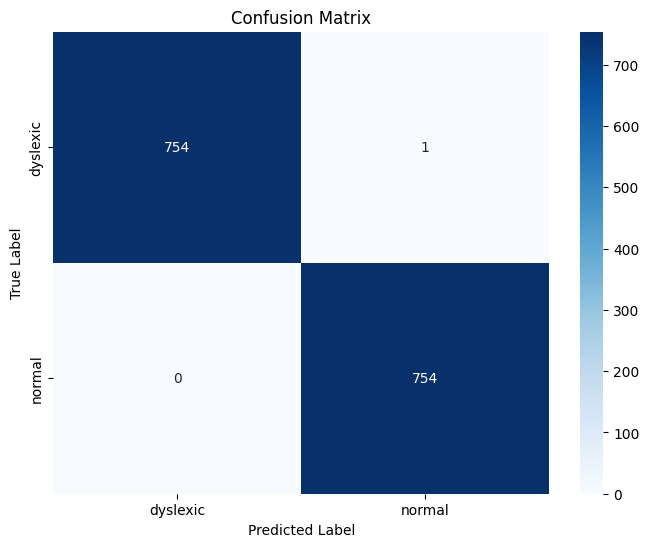


Classification Report:
              precision    recall  f1-score   support

    dyslexic       1.00      1.00      1.00       755
      normal       1.00      1.00      1.00       754

    accuracy                           1.00      1509
   macro avg       1.00      1.00      1.00      1509
weighted avg       1.00      1.00      1.00      1509



In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))